# 案例：在Dynex上实施支持向量机（SVM）算法

量子计算机用于机器学习的算法利用了量子力学的力量来增强机器学习任务的各个方面。以下是一些突出的量子计算机机器学习算法的摘要：

1. 量子支持向量机（QSVM）： QSVM是一种受量子启发的算法，旨在使用量子核函数对数据进行分类。它利用了量子叠加和量子特征映射的概念，可能在某些情况下相对于经典SVM算法提供计算优势。

2. 量子主成分分析（QPCA）： QPCA是经典主成分分析（PCA）算法的量子版本。它利用量子线性代数技术从高维数据中提取主成分，可能在量子机器学习中实现更高效的降维。

3. 量子神经网络（QNN）： QNN是经典神经网络的量子对应物。它利用量子原理，如量子叠加和纠缠，来处理和操作数据。QNN有潜力学习复杂的模式并执行分类和回归等任务，从量子并行性中受益。

4. 量子K均值聚类： 量子K均值是经典K均值聚类算法的量子启发变体。它使用量子算法同时探索多个解，以加速聚类过程。量子K均值有潜力加速大规模数据集的聚类任务。

5. 量子玻尔兹曼机（QBM）： QBM是经典玻尔兹曼机的量子模拟，后者是用于无监督学习的生成模型。QBM利用量子退火从概率分布中采样，并学习数据中的模式和结构。

6. 量子支持向量回归（QSVR）： QSVR将QSVM的概念扩展到回归任务。它使用量子计算技术执行回归分析，可能在效率和准确性方面相对于经典回归算法提供优势。

由于量子计算和神经形态计算在效率上具有相似性，上述所有算法都可以在Dynex平台上高效计算，但没有可用量子比特数量、纠错或可用性的限制。

在这个示例中，一个经典的分类模型，Kernel支持向量机，被实现为一个二次非约束二进制优化问题。在这里，数据点通过一个分离的超平面进行分类，同时最大化函数边际。该问题针对一个公共的Banknote Authentication数据集以及著名的Iris数据集使用Dynex神经形态计算平台来解决。

## 问题描述

支持向量机（Support Vector Machines，SVM）是用于分类和回归分析的监督学习模型。训练集被表示为 {x1, x2, ... xn}，它们是在某个空间 χ ∈ Rd 中的 d 维向量，其中 d 是每个向量的维度，即训练数据的属性数量。我们还给出它们的标签 {y1, y2, ..., yn}，其中 yi ∈ {1, -1}。SVM使用分离训练数据的最大间隔的超平面。一般来说，SVM允许将训练数据在空间 χ 投影到更高维的特征空间 F，其中 z = Φ(x)，其中 z ∈ F。为了找到具有最大间隔的最佳分离超平面，该算法最小化以下方程：

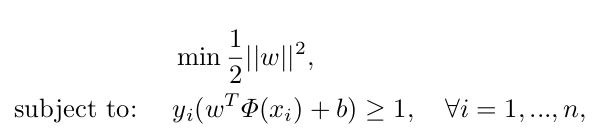

其中 w 是由方程 w = i αi yi K(xi, x) 给出的分离超平面的法向量，它可以通过最大化其原始拉格朗日形式转换为其对偶形式。这进一步被形式化为一个二次规划问题：

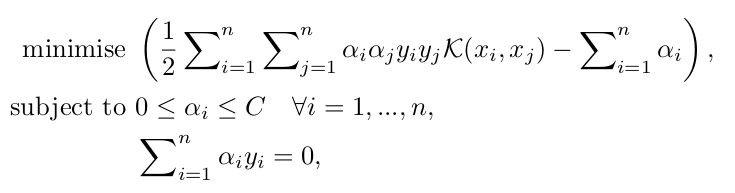

其中 αi 是分配给训练样本 xi 的权重。如果 αi > 0，则 xi 是一个支持向量。C 是一个正则化参数，用于控制在实现低训练错误和低测试错误之间的权衡，以便可以对未见数据进行泛化。函数 K(xi, xj) = Φ(xi)T Φ(xj) 是Mercer核函数，它允许我们在不明确知道非线性映射的情况下在高维空间中计算点积。有不同形式的核函数，然而，具有高能效参数的高斯核（或RBF核）的SVM因其在类别和特征之间具有非线性关系的情况下处理能力而备受欢迎。高斯核定义如下：

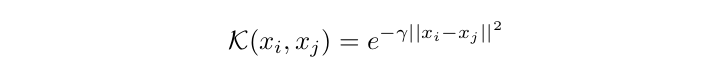

其中 γ > 0 是超参数。这些系数定义了一个决策边界，将向量空间分为两个区域，对应于预测的类标签。决策函数由支持向量完全确定，并用于预测最佳超平面周围的样本。它被形式化如下：

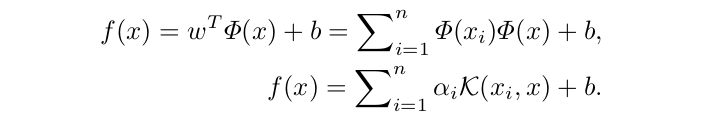

## QUBO公式化

将二次规划公式转化为QUBO公式需要两个主要步骤。首先，必须将输入转化为二进制输入，使用以下编码方式：

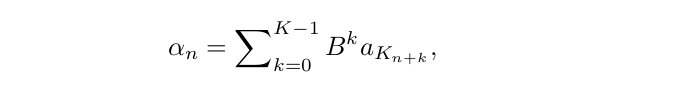

其中 aKn+k ∈ {0, 1} 为二进制变量，K 为编码 αn 所需的二进制变量数量，B 为用于编码的基数，通常情况下 B = 2。有关选择 K 的更多细节可以在参考文献中找到。第二步是将约束条件转化为目标函数，使用二次罚项的惩罚因子 ξ。 ξ 的值在训练阶段之前确定（如果不知道 ξ 的特定值，一个好的策略是尝试指数增长的序列，ξ = {..., 10^(-4), 10^(-3), 10^(-2), ...}）（我们已经优化了 ξ 的值）。

然后得到的目标函数如下：

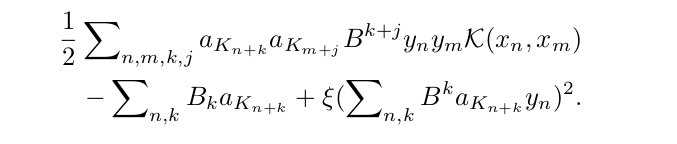

## 执行

首先，我们加载所有必需的库，包括Dynex SDK：

In [1]:
import dynex
import dimod

In [2]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import time 

正在创建一个加载训练数据的函数。在我们的实现中，我们将使用标准的银行票据认证数据集和著名的鸢尾花数据集：

In [3]:
def load_data(data_file,N,validation_pts):
    training_data = np.loadtxt('./datasets/{}.txt'.format(data_file), delimiter=',')\

    for i in range(N+validation_pts):
        if(training_data[i][-1] == 0):
            training_data[i][-1] = -1

    data = training_data[:N+validation_pts, :2]
    t = training_data[:N + validation_pts, -1]

    x_min, x_max = 1000, 0
    y_min, y_max = 1000, 0
    # rescalling data
    for i in range(N+validation_pts):
        x_min = min(data[i][0], x_min)
        x_max = max(data[i][0], x_max)
        y_min = min(data[i][1], y_min)
        y_max = max(data[i][1], y_max)

    for i in range(N+validation_pts):
        data[i][0] = (data[i][0] - x_min)/(x_max - x_min)
        data[i][1] = (data[i][1] - y_min)/(y_max - y_min)

    return data,t

接下来，我们构建一个支持向量机（Support-Vector-Machine）类，实现了上述算法。它支持五种采样器类型：

- **DNX** Dynex神经形态采样器
- **EXACT** 一种暴力的确切求解器，尝试所有组合。适用于非常有限的问题规模
- **QPU** 基于D-Wave量子处理器（QPU）的D-Wave采样器
- **HQPU** D-Wave Advantage混合求解器
- **SA** 使用D-Wave Ocean SDK中的SimulatedAnnealerSampler进行模拟退火

In [6]:
import neal
from HybridQRBM.samplers import DWaveSampler


def delta(i, j):
    if i == j:
        return 1
    else:
        return 0

class SVM:
    def __init__(self,B,K,C,gamma,xi,N,sampler_type) -> None:
        self.gamma = gamma
        self.B = B
        self.K = K 
        self.C = C 
        self.xi = xi 
        self.N = N
        self.sampler_type = sampler_type

        if(sampler_type == 'HQPU'):
            """self.sampler = LeapHybridSampler()"""
        if(sampler_type == 'SA'):
            self.sampler = neal.SimulatedAnnealingSampler()
        if(sampler_type == 'QPU'):
            """self.sampler = EmbeddingComposite(DWaveSampler())"""
        if(sampler_type == 'DNX'):
            self.sampler = '';
        if(sampler_type == 'EXACT'):
            self.sampler = dimod.ExactSolver();

        pass

    def kernel(self,x, y):
        if self.gamma == -1:
            k = np.dot(x, y)
        elif self.gamma >= 0:
            k = np.exp(-self.gamma*(np.linalg.norm(x-y, ord=2)))
        
        return k

    def predict_class(self,x_test, alpha, b):
        N = len(alpha)
        f = sum([alpha[n]*self.t[n]*self.kernel(self.data[n], x_test)
                    for n in range(N)]) + b
        return f

    def train_SVM(self,data,t):
        self.data = data 
        self.t = t 
        Q_tilde = np.zeros((self.K*self.N, self.K*self.N))
        for n in range(self.N):
            for m in range(self.N):
                for k in range(self.K):
                    for j in range(self.K):
                        Q_tilde[(self.K*n+k, self.K*m+j)] = 0.5*(self.B**(k+j))*t[n]*t[m] * \
                            (self.kernel(data[n], data[m])+self.xi) - \
                            (delta(n, m)*delta(k, j)*(self.B**k))

        Q = np.zeros((self.K*self.N, self.K*self.N))
        for j in range(self.K*self.N):
            Q[(j, j)] = Q_tilde[(j, j)]
            for i in range(self.K*self.N):
                if i < j:
                    Q[(i, j)] = Q_tilde[(i, j)] + Q_tilde[(j, i)]

        size_of_q = Q.shape[0]
        qubo = {(i, j): Q[i, j]
                for i, j in product(range(size_of_q), range(size_of_q))}

        now = time.perf_counter();
        
        if(self.sampler_type == 'HQPU'):
            response = self.sampler.sample_qubo(qubo)
        if(self.sampler_type == 'SA'):
            response = self.sampler.sample_qubo(qubo, num_reads=100)
        if(self.sampler_type == 'QPU'):
            response = self.sampler.sample_qubo(qubo, num_reads=100)
        if(self.sampler_type == 'EXACT'):
            response = self.sampler.sample_qubo(qubo)
        if(self.sampler_type == 'DNX'):
            bqm = dimod.BinaryQuadraticModel.from_qubo(qubo);
            model = dynex.BQM(bqm);
            sampler = dynex.DynexSampler(model, mainnet=True, description='QSVM');
            response = sampler.sample(num_reads=100000, annealing_time = 500);
            
        #print(f'Solver Time: {time.perf_counter() - now}') 

        a = response.first.sample

        alpha = {}
        for n in range(self.N):
            alpha[n] = sum([(self.B**k)*a[self.K*n+k] for k in range(self.K)])

        b = sum([alpha[n]*(self.C-alpha[n])*(t[n]-(sum([alpha[m]*t[m]*self.kernel(data[m], data[n])
                                                    for m in range(self.N)]))) for n in range(self.N)])/sum([alpha[n]*(self.C-alpha[n]) for n in range(self.N)])

        return alpha, b

模型预测类别的概率或确定性被定义为分类器的置信度。对于给定的数据点，决策函数的绝对值越高，该数据点属于特定类别的可能性就越大。我们创建一个函数来创建决策函数的等高线图，水平和垂直轴表示数据点，对应点的决策函数由颜色渐变表示：

In [7]:
def  plot_figure(SVM,alpha,data,t,b,N,sampler_type):
    plt.figure()
    cm = plt.cm.RdBu

    xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 80),
                            np.linspace(0.0, 1.0, 80))
    Z = []
    for row in range(len(xx)):
        Z_row = []
        for col in range(len(xx[row])):
            target = np.array([xx[row][col], yy[row][col]])
            Z_row.append(SVM.predict_class(target, alpha, b))
        Z.append(Z_row)

    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1,
                                                    0.1), cmap=cm, alpha=0.8, extend="both")

    plt.contour(xx, yy, Z, levels=[0.0], colors=(
        "black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    red_sv = []
    blue_sv = []
    red_pts = []
    blue_pts = []

    for i in range(N):
        if(alpha[i]):
            if(t[i] == 1):
                blue_sv.append(data[i, :2])
            else:
                red_sv.append(data[i, :2])

        else:
            if(t[i] == 1):
                blue_pts.append(data[i, :2])
            else:
                red_pts.append(data[i, :2])

    plt.scatter([el[0] for el in blue_sv],
                [el[1] for el in blue_sv], color='b', marker='^', edgecolors='k', label="Type 1 SV")

    plt.scatter([el[0] for el in red_sv],
                [el[1] for el in red_sv], color='r', marker='^', edgecolors='k', label="Type -1 SV")

    plt.scatter([el[0] for el in blue_pts],
                [el[1] for el in blue_pts], color='b', marker='o', edgecolors='k', label="Type 1 Train")

    plt.scatter([el[0] for el in red_pts],
                [el[1] for el in red_pts], color='r', marker='o', edgecolors='k', label="Type -1 Train")

    
    plt.legend(loc='lower right', fontsize='x-small')
    plt.savefig(f'{sampler_type}.jpg')

def compute_metrics(SVM,alpha,data,t,b,N,validation_pts):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(N, N+validation_pts):
        predicted_cls = SVM.predict_class(data[i], alpha, b)
        y_i = t[i]
        if(y_i == 1):
            if(predicted_cls > 0):
                tp += 1
            else:
                fp += 1
        else:
            if(predicted_cls < 0):
                tn += 1
            else:
                fn += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = tp/(tp + 1/2*(fp+fn))
    accuracy = (tp + tn)/(tp+tn+fp+fn)

    return precision,recall,f_score,accuracy



## 计算（主网）

模拟是使用以下参数值运行的：K = 2，B = 2，C = 3，ξ = 0.001，γ = 16。我们不打算优化 C 和 γ，因为我们的目标是研究相同超参数的行为。然而，ξ 已经在参考文献中由作者进行了优化：

In [17]:
B = 2;
K = 2;
C = 3;
gamma = 16;
xi = 0.001;
dataPoints = 150; # size of data points
spl = "DNX";     # sampler
trainingPoints = int(dataPoints * 0.80)
validationPoints = dataPoints - trainingPoints; 
print('Training set:', trainingPoints,'validation set:',validationPoints, 'total:',dataPoints)

Training set: 120 validation set: 30 total: 150


首先加载数据

In [18]:
data,t = load_data('banknote_1',trainingPoints,validationPoints)

创建支持向量机并给数据

In [19]:
_SVM = SVM(B,K,C,gamma,xi,trainingPoints,spl)

开始训练

In [20]:
alpha, b = _SVM.train_SVM(data, t)

╭────────────┬───────────┬───────────┬─────────┬────────┬─────────┬───────┬──────┬──────────┬────────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS │   CHIPS │      ✔ │   STEPS │   LOC │    ✔ │   ENERGY │          ✔ │
├────────────┼───────────┼───────────┼─────────┼────────┼─────────┼───────┼──────┼──────────┼────────────┤
│       5029 │      0.35 │         4 │ 1554222 │ 114176 │     500 │  4621 │ 4621 │  7272542 │ 7276642.00 │
╰────────────┴───────────┴───────────┴─────────┴────────┴─────────┴───────┴──────┴──────────┴────────────╯
╭───────────┬───────────────┬─────────┬───────┬────────────┬────────────┬───────────────┬──────────╮
│    WORKER │       VERSION │   CHIPS │   LOC │     ENERGY │    RUNTIME │   LAST UPDATE │   STATUS │
├───────────┼───────────────┼─────────┼───────┼────────────┼────────────┼───────────────┼──────────┤
│ 133963327 │ 2.3.0.SRB.234 │  100000 │ 14294 │ 7272542.00 │   0.75 min │     1.00s ago │  STOPPED │
├───────────┼───────────────┼─────────┼───────┼────────────┼─

使用绘制图表和打印指标的函数，我们分析结果：

In [ ]:
plot_figure(_SVM,alpha,data,t,b,trainingPoints,spl)

In [21]:
precision,recall,f_score,accuracy = compute_metrics(_SVM,alpha,data,t,b,trainingPoints,validationPoints)
print(f'{precision=} {recall=} {f_score=} {accuracy=}')

precision=1.0 recall=0.8823529411764706 f_score=0.9375 accuracy=0.9333333333333333


以下图表显示了在D-Wave系统上使用上述各种采样器进行的实验结果。请注意，作者观察到QPU不能为大于90的实例找到嵌入：

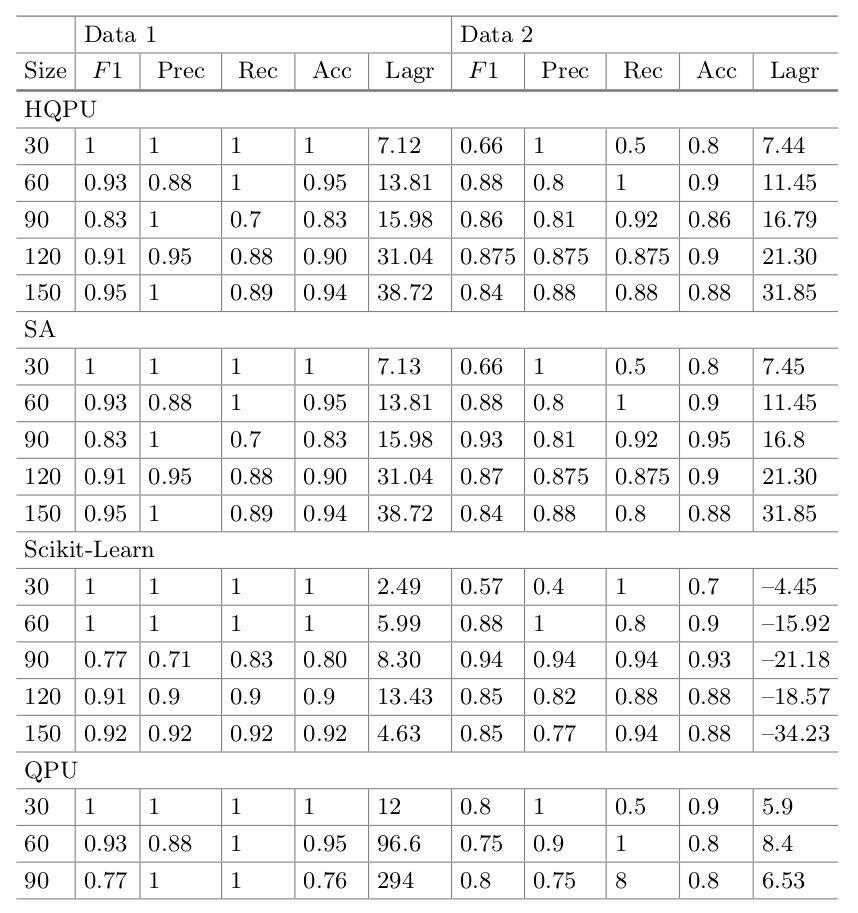

## 参考文献

[1] Harshil Singh Bhatia and Frank Phillipson: Performance Analysis of Support Vector Machine Implementations on the D-Wave Quantum Annealer, International Conference on Computational Science, p.84-97, 2021, Springer

[2] Booth, M., Reinhardt, S.P., Roy, A.: Partitioning Optimization Problems for Hybrid Classical/Quantum Execution. Technical report, D-Wave Systems (2017)

[3] Chang, C.C., Lin, C.J.: LIBSVM: a library for support vector machines. ACM Trans. Intell. Syst. Technol. 2, 27:1–27:27.

[4] Chatterjee, R., Yu, T.: Generalized coherent states, reproducing kernels, and quantum support vector machines. Quantum Inf. Comput. 17(15–16), 1292–1306 (2017)

[5] Choi, V.: Minor-embedding in adiabatic quantum computation: I. the parameter setting problem. Quantum Inf. Process. 7(5), 193–209 (2008)

[6] Coﬀrin, C.J.: Challenges with chains: testing the limits of a d-wave quantum annealer for discrete optimization. Technical report, Los Alamos National Lab. (LANL), Los Alamos, NM (United States) (2019)

[7] Willsch, D., Willsch, M., De Raedt, H., Michielsen, K.: Support vector machines on the d-wave quantum annealer. Comput. Phys. Commun. 248, 107006 (2020)